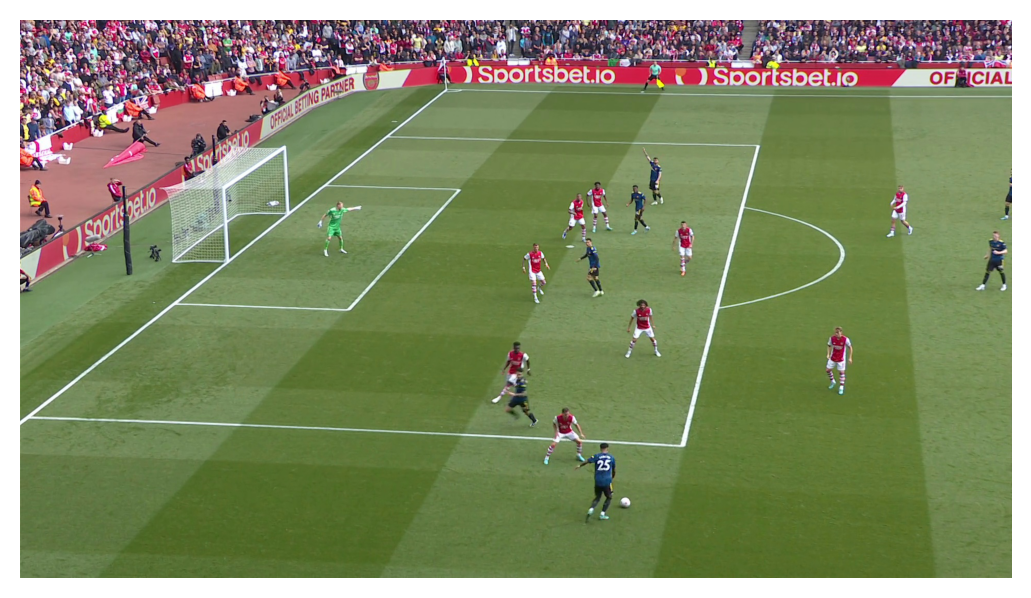

In [1]:
import base64
import json
import io
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
with open('example-football-pitch-image.jpg', "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
image_data = base64.b64decode(encoded_string)
image = Image.open(io.BytesIO(image_data))
plt.gcf().set_dpi(200)
plt.axis('off')
plt.imshow(image)
plt.show()


In [2]:
import oci
config = oci.config.from_file('~/.oci/config')
ai_service_vision_client = oci.ai_vision.AIServiceVisionClient(config=config)
analyze_image_details = oci.ai_vision.models.AnalyzeImageDetails()
inline_image_details = oci.ai_vision.models.InlineImageDetails()
image_object_detection_feature = oci.ai_vision.models.ImageObjectDetectionFeature()
image_object_detection_feature.max_results = 255
image_text_detection_feature = oci.ai_vision.models.ImageTextDetectionFeature()
features = [image_object_detection_feature, image_text_detection_feature]
inline_image_details.data = encoded_string.decode('utf-8')
analyze_image_details.image = inline_image_details
analyze_image_details.features = features
res = ai_service_vision_client.analyze_image(analyze_image_details=analyze_image_details)
res_json = json.loads(repr(res.data))
f = open('vision_response.json', 'w')
json.dump(res_json, f)


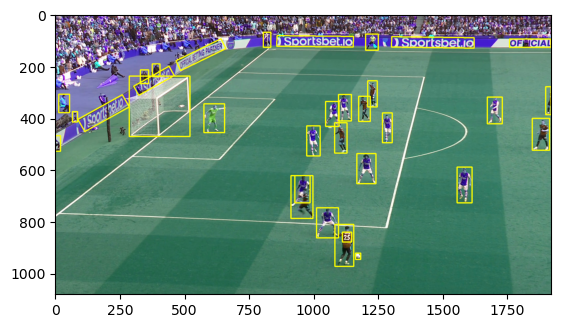

In [3]:
import cv2
def draw_bounding_boxes(objects, img):
    width = img.shape[1]
    height = img.shape[0]
    # Loop through all of the players found
    for obj in objects:
        point1 = (int(obj["bounding_polygon"]["normalized_vertices"][0]["x"] * width), int(obj["bounding_polygon"]["normalized_vertices"][0]["y"] * height))
        point2 = (int(obj["bounding_polygon"]["normalized_vertices"][1]["x"] * width), int(obj["bounding_polygon"]["normalized_vertices"][1]["y"] * height))
        point3 = (int(obj["bounding_polygon"]["normalized_vertices"][2]["x"] * width), int(obj["bounding_polygon"]["normalized_vertices"][2]["y"] * height))
        point4 = (int(obj["bounding_polygon"]["normalized_vertices"][3]["x"] * width), int(obj["bounding_polygon"]["normalized_vertices"][3]["y"] * height))
        color = (255, 255, 0)
        cv2.line(img, point1, point2, color, 4)
        cv2.line(img, point2, point3, color, 4)
        cv2.line(img, point3, point4, color, 4)
        cv2.line(img, point4, point1, color, 4)

img = cv2.imread('example-football-pitch-image.jpg')
draw_bounding_boxes(res_json["image_objects"], img)
draw_bounding_boxes(res_json["image_text"]["lines"], img)
plt.imshow(img)
plt.show()

In [4]:
def is_point_within_rectangle(object_rectangle, text_rectangle):
    #This is used to check whether the detected number is inside of a detected player
    #If it is, then it is a shirt number
    #If it is not, it's likely a commercial message outside of the field
    minX = 1
    maxX = 0
    minY = 1
    maxY = 0
    for coordinate in object_rectangle:
        if coordinate["x"] < minX:
            minX = coordinate["x"]
        if coordinate["y"] < minY:
            minY = coordinate["y"]
        if coordinate["x"] > maxX:
            maxX = coordinate["x"]
        if coordinate["y"] > maxY:
            maxY = coordinate["y"]
    result = text_rectangle[0]["x"] > minX and text_rectangle[0]["y"] > minY and text_rectangle[0]["x"] < maxX and text_rectangle[0]["y"] < maxY and text_rectangle[1]["x"] > minX and text_rectangle[1]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[1]["y"] < maxY and text_rectangle[2]["x"] > minX and text_rectangle[2]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[2]["y"] < maxY and text_rectangle[3]["x"] > minX and text_rectangle[3]["y"] > minY and text_rectangle[1]["x"] < maxX and text_rectangle[3]["y"] < maxY
    return result
def add_shirt_number_to_players(vision_response):
    # Loop through all of the players found
    for image_object in vision_response["image_objects"]:
        # Loop through all of the texts found
        # Check if it is within the bounds of this player
        # If it is, then set it as the shirt number
        for line in vision_response["image_text"]["lines"]:
            result = is_point_within_rectangle(image_object["bounding_polygon"]["normalized_vertices"], line["bounding_polygon"]["normalized_vertices"])
            if (result is True):
                image_object["shirt_number"] = line["text"]
add_shirt_number_to_players(res_json)
f = open('vision_response_enriched_with_shirt_numbers.json', 'w')
json.dump(res_json, f)


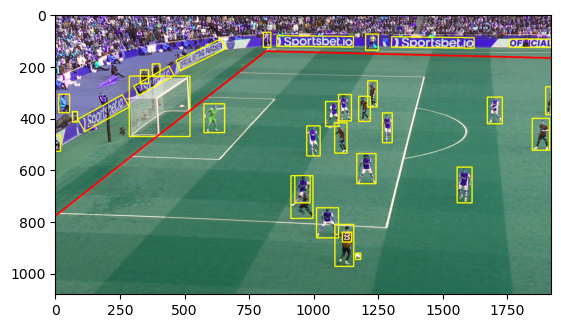

In [6]:
def draw_line_with_field_coordinates(field_coordinate1, field_coordinate2, img, field_to_camera):
    # provide a point you wish to map from image 1 to image 2
    a = np.array([field_coordinate1], dtype='float32')
    a = np.array([a])
    #print("a", a)
    b = np.array([field_coordinate2], dtype='float32')
    b = np.array([b])
    # finally, get the mapping
    pointsOut1 = cv2.perspectiveTransform(a, field_to_camera)
    pointsOut2 = cv2.perspectiveTransform(b, field_to_camera)
    coordinate1 = pointsOut1[0][0]
    coordinate1int = coordinate1.astype(int)
    coordinate1tuple = (coordinate1int[0], coordinate1int[1])
    #print(coordinate1tuple)
    coordinate2 = pointsOut2[0][0]
    coordinate2int = coordinate2.astype(int)
    coordinate2tuple = (coordinate2int[0], coordinate2int[1])
    #print(coordinate2tuple)
    cv2.line(img, coordinate1tuple, coordinate2tuple, (255, 0, 0), 5)
# Read the precalculated homography translation matrices (for all frames)
import numpy as np
f = open('coordinate_pairs.json', 'r')
homography_str = f.read()
homography_dict = json.loads(homography_str)

frame_coordinate_pairs = homography_dict["23"]
pts_dst = np.array([frame_coordinate_pairs[0]["worldCoordinate"], frame_coordinate_pairs[1]["worldCoordinate"], frame_coordinate_pairs[2]["worldCoordinate"], frame_coordinate_pairs[3]["worldCoordinate"]])
pts_src = np.array([frame_coordinate_pairs[0]["cameraCoordinate"], frame_coordinate_pairs[1]["cameraCoordinate"], frame_coordinate_pairs[2]["cameraCoordinate"], frame_coordinate_pairs[3]["cameraCoordinate"]])
camera_to_field, status = cv2.findHomography(pts_src, pts_dst)
field_to_camera, status = cv2.findHomography(pts_dst, pts_src)
FIELD_HEIGHT = 65
FIELD_WIDTH = 105
draw_line_with_field_coordinates([0, -FIELD_HEIGHT / 2], [0, FIELD_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([0, FIELD_HEIGHT / 2], [FIELD_WIDTH, FIELD_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([FIELD_WIDTH, FIELD_HEIGHT / 2], [FIELD_WIDTH, -FIELD_HEIGHT / 2], img, field_to_camera)
draw_line_with_field_coordinates([FIELD_WIDTH, -FIELD_HEIGHT / 2], [0, -FIELD_HEIGHT / 2], img, field_to_camera)
#ADD YOUR OWN CODE HERE TO DRAW THE PENALTY AREA
plt.imshow(img)
plt.show()
